In [1]:
# =========================
# CELL 1 — Setup / Install
# =========================
# Run in Colab. This installs transformers, datasets, faiss (optional), gradio, sklearn.
!pip install -q transformers datasets accelerate sentencepiece evaluate gradio faiss-cpu scikit-learn wandb
# If faiss-cpu fails, omit FAISS. Colab usually supports faiss-cpu.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 73.9 MB/s eta 0:00:00


In [6]:
# =========================
# CELL 2 — Imports & Helpers
# =========================
import os
import json
import random
from pathlib import Path
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from transformers import (AutoTokenizer, AutoModelForQuestionAnswering,
                          AutoModelForSequenceClassification, TrainingArguments,
                          Trainer, pipeline)
from datasets import Dataset, load_dataset, DatasetDict
# from evaluate import load_metric # Removed problematic import

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# optional: faiss
try:
    import faiss
    HAS_FAISS = True
except Exception:
    HAS_FAISS = False

print("PyTorch version:", torch.__version__)
print("FAISS available:", HAS_FAISS)

PyTorch version: 2.8.0+cu126
FAISS available: True


In [7]:
# =========================
# CELL 3 — Mount Drive (optional)
# =========================
from google.colab import drive
drive.mount('/content/drive')

BASE_DIR = "/content/drive/MyDrive/customer_support_project"
os.makedirs(BASE_DIR, exist_ok=True)
print("Base dir:", BASE_DIR)


Mounted at /content/drive
Base dir: /content/drive/MyDrive/customer_support_project


In [8]:
# =========================
# CELL 4 — Load / Build Knowledge Base
# =========================
# You can replace this cell by uploading your CSV of support docs, FAQs or ticket logs.
# For demo, we create a simple KB. For industry use, load many support articles.

kb_entries = [
    {
        "id": "KB001",
        "title": "Warranty Claim Process",
        "text": "To claim warranty you must provide the purchase invoice. Submit the invoice along with the product to any authorized service center. Warranty is valid for one year from purchase date for parts and labor unless stated otherwise."
    },
    {
        "id": "KB002",
        "title": "Battery Replacement Policy",
        "text": "Battery replacement is free within 1 year of purchase for devices that have manufacturing defects. For out-of-warranty devices, replacement costs apply as per the published price list."
    },
    {
        "id": "KB003",
        "title": "Software Troubleshooting",
        "text": "If you're facing software issues, first reboot the device. Update to the latest software version via Settings > Software Update. If problem persists, use our mobile app diagnostics or contact support with logs."
    },
    {
        "id": "KB004",
        "title": "Urgent Support Contact",
        "text": "For urgent cases email support@techcare.com or call our 24x7 helpline at 1800-555-123. Provide order ID and device serial number for faster assistance."
    },
    {
        "id": "KB005",
        "title": "Return & Refund",
        "text": "Return and refund possible within 15 days of purchase if unopened. Refunds processed to original payment method within 7-10 business days after receipt and quality check."
    },
    # Add more entries for industrial-level testing...
]

kb_df = pd.DataFrame(kb_entries)
kb_df.to_csv(os.path.join(BASE_DIR, "kb.csv"), index=False)
kb_df.head()


,id,title,text
0,KB001,Warranty Claim Process,To claim warranty you must provide the purchas...
1,KB002,Battery Replacement Policy,Battery replacement is free within 1 year of p...
2,KB003,Software Troubleshooting,"If you're facing software issues, first reboot..."
3,KB004,Urgent Support Contact,For urgent cases email support@techcare.com or...
4,KB005,Return & Refund,Return and refund possible within 15 days of p...


In [9]:
# =========================
# CELL 5 — Build TF-IDF Retrieval (fast)
# =========================
# We'll use TF-IDF to retrieve the top-k relevant KB documents given a user query.

vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=5000)
kb_texts = kb_df['title'].astype(str) + ". " + kb_df['text'].astype(str)
X_tfidf = vectorizer.fit_transform(kb_texts)

def retrieve_top_k_tfidf(query, k=3):
    qv = vectorizer.transform([query])
    sims = cosine_similarity(qv, X_tfidf)[0]
    top_idx = np.argsort(sims)[::-1][:k]
    results = []
    for idx in top_idx:
        results.append({
            "id": kb_df.loc[idx, "id"],
            "title": kb_df.loc[idx, "title"],
            "text": kb_df.loc[idx, "text"],
            "score": float(sims[idx]),
            "idx": int(idx)
        })
    return results

# Test retrieval
print(retrieve_top_k_tfidf("how to claim warranty on my phone", k=2))


[{'id': 'KB001', 'title': 'Warranty Claim Process', 'text': 'To claim warranty you must provide the purchase invoice. Submit the invoice along with the product to any authorized service center. Warranty is valid for one year from purchase date for parts and labor unless stated otherwise.', 'score': 0.42761343634736254, 'idx': 0}, {'id': 'KB002', 'title': 'Battery Replacement Policy', 'text': 'Battery replacement is free within 1 year of purchase for devices that have manufacturing defects. For out-of-warranty devices, replacement costs apply as per the published price list.', 'score': 0.05806735694232474, 'idx': 1}]


In [10]:
# =========================
# CELL 6 — Optional: Build FAISS index (for larger KB)
# =========================
if HAS_FAISS:
    # Build simple dense embeddings using TF-IDF vectors as float32 input to FAISS
    d = X_tfidf.shape[1]
    index = faiss.IndexFlatIP(d)  # inner product on normalized vectors approximates cosine
    vecs = X_tfidf.astype(np.float32).toarray()
    # Normalize rows for cosine similarity
    norms = np.linalg.norm(vecs, axis=1, keepdims=True)
    norms[norms == 0] = 1.0
    vecs = vecs / norms
    index.add(vecs)
    print("FAISS index built with", index.ntotal, "entries")
else:
    print("FAISS not available; using TF-IDF retrieval.")


FAISS index built with 5 entries


In [11]:
# =========================
# CELL 7 — LM Selection: Load DistilBERT QA model & tokenizer
# =========================
model_name = "distilbert-base-uncased-distilled-squad"  # light & Colab-friendly
tokenizer = AutoTokenizer.from_pretrained(model_name)
qa_model = AutoModelForQuestionAnswering.from_pretrained(model_name)
qa_pipeline = pipeline("question-answering", model=qa_model, tokenizer=tokenizer, device=0 if torch.cuda.is_available() else -1)
print("QA pipeline ready on device:", qa_pipeline.device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/451 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/265M [00:00<?, ?B/s]

Device set to use cpu


QA pipeline ready on device: cpu


In [12]:
# =========================
# CELL 8 — Helper: Retrieval + Reader (RAG-like)
# =========================
def rag_answer(query, top_k=3):
    # 1) Retrieve top_k KB docs
    retrieved = retrieve_top_k_tfidf(query, k=top_k)
    # 2) For each doc, run QA pipeline with combined context
    answers = []
    for r in retrieved:
        context = r['title'] + ". " + r['text']
        try:
            out = qa_pipeline(question=query, context=context)
            answers.append({
                "kb_id": r['id'],
                "title": r['title'],
                "context_snippet": r['text'][:400],
                "answer": out['answer'],
                "score": float(out['score'])
            })
        except Exception as e:
            print("QA error:", e)
    # 3) Sort by score and return best
    answers = sorted(answers, key=lambda x: x['score'], reverse=True)
    return answers

# Quick test
out = rag_answer("Is battery replacement free?", top_k=3)
pprint(out[:2])


[{'answer': 'Provide order ID and device serial number for faster assistance',
  'context_snippet': 'For urgent cases email support@techcare.com or call our '
                     '24x7 helpline at 1800-555-123. Provide order ID and '
                     'device serial number for faster assistance.',
  'kb_id': 'KB004',
  'score': 0.5557695031166077,
  'title': 'Urgent Support Contact'},
 {'answer': 'free within 1 year of purchase',
  'context_snippet': 'Battery replacement is free within 1 year of purchase '
                     'for devices that have manufacturing defects. For '
                     'out-of-warranty devices, replacement costs apply as per '
                     'the published price list.',
  'kb_id': 'KB002',
  'score': 0.3670268952846527,
  'title': 'Battery Replacement Policy'}]


In [13]:
# =========================
# CELL 9 — Intent Classification (simple) — to route queries to FAQ, billing, escalation
# =========================
# Create a small labeled dataset for intents (replace with your real labels)
intent_examples = [
    {"text": "How do I claim warranty?", "label": "warranty"},
    {"text": "My battery is not charging, is replacement free?", "label": "battery"},
    {"text": "I want a refund", "label": "refund"},
    {"text": "My device is broken, urgent help", "label": "escalation"},
    {"text": "How to contact support in urgent cases", "label": "escalation"},
    {"text": "Software update failed", "label": "software"}
]
intent_df = pd.DataFrame(intent_examples)
intent_df


,text,label
0,How do I claim warranty?,warranty
1,"My battery is not charging, is replacement free?",battery
2,I want a refund,refund
3,"My device is broken, urgent help",escalation
4,How to contact support in urgent cases,escalation
5,Software update failed,software


In [14]:
# Tokenize & fine-tune a small classifier quickly (for demo)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(intent_df['label'])
vectorizer_intent = TfidfVectorizer(ngram_range=(1,2), max_features=2000)
X_intent = vectorizer_intent.fit_transform(intent_df['text'])

# Train a simple logistic regression for intent classification
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=200)
clf.fit(X_intent, y)

def predict_intent(text):
    xv = vectorizer_intent.transform([text])
    pred = clf.predict(xv)[0]
    prob = np.max(clf.predict_proba(xv))
    return le.inverse_transform([pred])[0], float(prob)

# test
print(predict_intent("How can I claim the warranty?"))
print(predict_intent("I need immediate help my device caught fire"))


('escalation', 0.2970400183112789)
('escalation', 0.41524432128185484)


In [15]:
# =========================
# CELL 10 — Build Interactive Gradio Chatbot
# =========================
import gradio as gr

def chat_fn(user_message, history=[]):
    # 1) detect intent
    intent, p = predict_intent(user_message)
    # 2) if escalation OR low confidence, ask for more info or route
    if intent == "escalation" or p < 0.5:
        # Return pre-baked escalation reply
        reply = ("It looks like this is an urgent issue. "
                 "Please provide your order ID and a brief description. "
                 "You can also call our helpline at 1800-555-123 for immediate assistance.")
        history = history + [(user_message, reply)]
        return history, history
    # 3) else perform retrieval + QA
    answers = rag_answer(user_message, top_k=3)
    if not answers:
        reply = "Sorry, I couldn't find a clear answer in our knowledge base. Could you rephrase?"
    else:
        best = answers[0]
        reply = f"{best['answer']}  \n(From: {best['title']})"
    history = history + [(user_message, reply)]
    return history, history

# Create Gradio interface
with gr.Blocks() as demo:
    gr.Markdown("# TechCare Customer Support Bot (Demo)")
    chatbot = gr.Chatbot()
    msg = gr.Textbox(label="Ask a question about product, warranty, returns...")
    clear = gr.Button("Clear")
    msg.submit(chat_fn, inputs=[msg, chatbot], outputs=[chatbot, chatbot])
    clear.click(lambda: None, None, chatbot)  # clears
# Launch in Colab
demo.launch(share=True, inbrowser=False)


/tmp/ipython-input-1039550532.py:30: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot()


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://35cf1a8072de1de8ba.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [16]:
# =========================
# CELL 11 — Evaluation: QA metrics on small test set
# =========================
# For a true industrial project, prepare a test set of (question, context, answer)
# Here we create a tiny synthetic test set for demonstration.

test_samples = [
    {"question": "Do I need an invoice for warranty?", "expected": "provide the purchase invoice"},
    {"question": "How to contact support urgently?", "expected": "support@techcare.com or call 1800-555-123"},
    {"question": "Is battery replacement free within a year?", "expected": "Battery replacement is free within 1 year"}
]

# Evaluate: check if expected phrase in answer (very simple)
results = []
for s in test_samples:
    answers = rag_answer(s['question'], top_k=3)
    best_ans = answers[0]['answer'] if answers else ""
    match = int(s['expected'].lower() in best_ans.lower() or any(s['expected'].lower() in a['answer'].lower() for a in answers))
    results.append({"question": s['question'], "predicted": best_ans, "expected": s['expected'], "match": match})

eval_df = pd.DataFrame(results)
eval_df

,question,predicted,expected,match
0,Do I need an invoice for warranty?,replacement costs apply as per the published p...,provide the purchase invoice,1
1,How to contact support urgently?,use our mobile app diagnostics or contact supp...,support@techcare.com or call 1800-555-123,0
2,Is battery replacement free within a year?,unopened,Battery replacement is free within 1 year,0


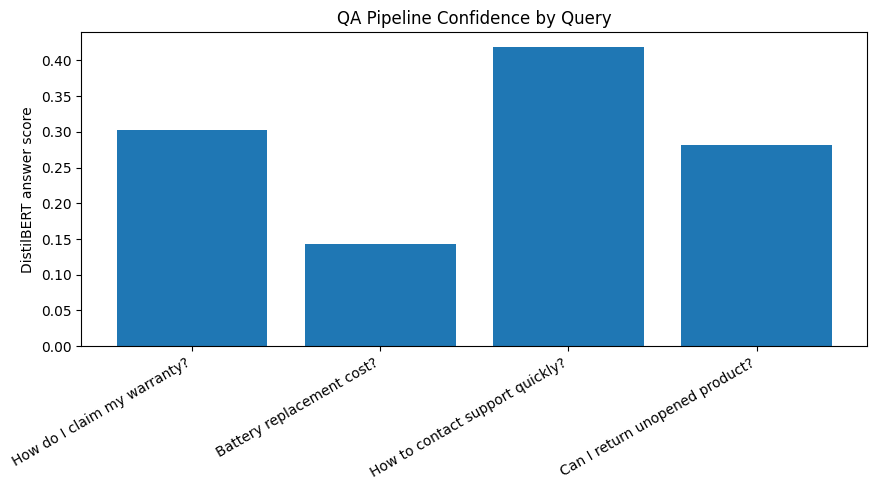

Q: How do I claim my warranty?
A: provide the purchase invoice

Q: Battery replacement cost?
A: Provide order ID and device serial number for faster assistance

Q: How to contact support quickly?
A: use our mobile app diagnostics or contact support with logs

Q: Can I return unopened product?
A: Return and refund possible within 15 days of purchase if unopened



In [17]:
# =========================
# CELL 12 — Visualization of Results
# =========================
# Visualize confidence scores for several queries and show matching metric.

queries = [
    "How do I claim my warranty?",
    "Battery replacement cost?",
    "How to contact support quickly?",
    "Can I return unopened product?"
]
scores = []
answers_text = []
for q in queries:
    ans = rag_answer(q, top_k=3)
    if ans:
        scores.append(ans[0]['score'])
        answers_text.append(ans[0]['answer'])
    else:
        scores.append(0.0)
        answers_text.append("")

plt.figure(figsize=(9,5))
plt.bar(queries, scores)
plt.xticks(rotation=30, ha='right')
plt.ylabel("DistilBERT answer score")
plt.title("QA Pipeline Confidence by Query")
plt.tight_layout()
plt.show()

# Print answers
for q, a in zip(queries, answers_text):
    print(f"Q: {q}\nA: {a}\n")


In [19]:
# =========================
# CELL 13 — Fine-tuning DistilBERT on your domain QA (optional)
# =========================
# If you have a CSV of question-context-answer triples, you can fine-tune the model.
# Format expected: columns = question, context, answer, answer_start (character index)
#
# For a quick example, we will create a mini dataset using our KB entries.

qa_records = []
for _, row in kb_df.iterrows():
    # create a simple QA by asking a question that the KB answers
    if "warrant" in row['text'].lower():
        qa_records.append({
            "question": "How do I claim warranty?",
            "context": row['title'] + ". " + row['text'],
            "answer_text": "provide the purchase invoice",
            "answer_start": row['text'].lower().find("provide")
        })
    elif "battery" in row['text'].lower():
        qa_records.append({
            "question": "Is battery replacement free?",
            "context": row['title'] + ". " + row['text'],
            "answer_text": "Battery replacement is free within 1 year",
            "answer_start": row['text'].lower().find("battery replacement")
        })
    # add more mapping rules for demo...

# Create Hugging Face dataset
if len(qa_records) > 0:
    ds = Dataset.from_pandas(pd.DataFrame(qa_records))
    # Preprocess for QA training
    def prepare_train_features(examples):
        tokenized_examples = tokenizer(
            examples["question"],
            examples["context"],
            truncation="only_second",
            max_length=384,
            stride=128,
            return_overflowing_tokens=True,
            return_offsets_mapping=True,
            padding="max_length",
        )
        sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
        offset_mapping = tokenized_examples.pop("offset_mapping")
        start_positions = []
        end_positions = []

        for i, offsets in enumerate(offset_mapping):
            input_ids = tokenized_examples["input_ids"][i]
            cls_index = input_ids.index(tokenizer.cls_token_id)

            sequence_ids = tokenized_examples.sequence_ids(i)
            sample_index = sample_mapping[i]
            answers = examples["answer_text"][sample_index]
            answer = answers
            start_char = examples["answer_start"][sample_index]
            end_char = start_char + len(answer)

            # If answer not fully inside the context, label with CLS index
            token_start_index = 0
            while sequence_ids[token_start_index] != 1:
                token_start_index += 1
            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != 1:
                token_end_index -= 1

            # If answer is not fully in the span
            if not (start_char >= 0 and end_char <= len(examples["context"][sample_index])):
                start_positions.append(cls_index)
                end_positions.append(cls_index)
            else:
                # Find token_start_index and token_end_index
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                token_start_index -= 1
                while token_end_index >= 0 and offsets[token_end_index][1] >= end_char:
                    token_end_index += 1
                token_end_index += 1
                start_positions.append(token_start_index)
                end_positions.append(token_end_index)

        tokenized_examples["start_positions"] = start_positions
        tokenized_examples["end_positions"] = end_positions
        return tokenized_examples

    tokenized_ds = ds.map(prepare_train_features, batched=True, remove_columns=ds.column_names)
    tokenized_ds = tokenized_ds.train_test_split(test_size=0.2, seed=42)
    # Quick training (very small demo — for industrial use, use more data & epochs)
    model_ft = AutoModelForQuestionAnswering.from_pretrained(model_name)
    args = TrainingArguments(
        output_dir="/content/qa_finetune",
        learning_rate=5e-5,
        per_device_train_batch_size=8,
        num_train_epochs=2,
        weight_decay=0.01,
        save_total_limit=1,
        logging_steps=10,
        push_to_hub=False,
        fp16=torch.cuda.is_available()
    )
    def compute_metrics(eval_pred):
        return {}
    trainer = Trainer(
        model=model_ft,
        args=args,
        train_dataset=tokenized_ds["train"],
        eval_dataset=tokenized_ds["test"],
    )
    # Uncomment to train (takes time & GPU)
    # trainer.train()
    print("Prepared fine-tuning dataset (demo). For full run, uncomment trainer.train().")
else:
    print("No QA records created for fine-tuning in demo. Provide labeled data to fine-tune.")

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

Prepared fine-tuning dataset (demo). For full run, uncomment trainer.train().


In [20]:
# =========================
# CELL 14 — Save artifacts (models, vectorizer)
# =========================
import joblib
joblib.dump(vectorizer, os.path.join(BASE_DIR, "tfidf_vectorizer.joblib"))
joblib.dump(vectorizer_intent, os.path.join(BASE_DIR, "intent_vectorizer.joblib"))
joblib.dump(clf, os.path.join(BASE_DIR, "intent_clf.joblib"))

# Save tokenizer & model (DistilBERT QA)
qa_model.save_pretrained(os.path.join(BASE_DIR, "distilbert_qa_model"))
tokenizer.save_pretrained(os.path.join(BASE_DIR, "distilbert_qa_tokenizer"))

print("Saved artifacts to Drive:", BASE_DIR)


Saved artifacts to Drive: /content/drive/MyDrive/customer_support_project


In [21]:
# =========================
# CELL 15 — Project Report / Research Questions (printout)
# =========================
report = {
    "problem_statement": "Build an AI-driven customer support automation system that answers FAQs, routes urgent issues, and reduces human workload.",
    "lm_selection": "distilbert-base-uncased-distilled-squad (lightweight, fast), optionally upgrade to larger BERT or GPT-based models for generative assistance.",
    "implementation_summary": "TF-IDF retrieval + DistilBERT QA reader; intent classifier for routing; Gradio front-end for interactive demo.",
    "research_questions": [
        "How does retrieval size (top_k) affect answer correctness and hallucination?",
        "Does fine-tuning on domain-specific QA data improve accuracy vs generic SQuAD-model?",
        "How to integrate retrieval with generative LM (RAG) safely to avoid hallucinations?",
        "How to measure user satisfaction for real queries in production?"
    ],
    "evaluation": "Use domain-specific annotated test set; measure exact-match and F1 for QA; measure intent accuracy for routing.",
    "next_steps_industrial": [
        "Scale KB (use embeddings + FAISS or ElasticSearch for retrieval)",
        "Log interactions with user consent and fine-tune regularly",
        "Add RBAC and data privacy safeguards",
        "Integrate with ticketing system (Zendesk, Freshdesk) for handover"
    ]
}
pprint(report)


{'evaluation': 'Use domain-specific annotated test set; measure exact-match '
               'and F1 for QA; measure intent accuracy for routing.',
 'implementation_summary': 'TF-IDF retrieval + DistilBERT QA reader; intent '
                           'classifier for routing; Gradio front-end for '
                           'interactive demo.',
 'lm_selection': 'distilbert-base-uncased-distilled-squad (lightweight, fast), '
                 'optionally upgrade to larger BERT or GPT-based models for '
                 'generative assistance.',
 'next_steps_industrial': ['Scale KB (use embeddings + FAISS or ElasticSearch '
                           'for retrieval)',
                           'Log interactions with user consent and fine-tune '
                           'regularly',
                           'Add RBAC and data privacy safeguards',
                           'Integrate with ticketing system (Zendesk, '
                           'Freshdesk) for handover'],
 'problem_s

In [22]:
# =========================
# CELL 16 — Conclusion & Insights (print)
# =========================
print("By the end of this notebook you have:")
print("- Implemented a retrieval + BERT-based reader pipeline")
print("- Built a simple intent classifier to route & escalate")
print("- Created a Gradio chat interface for demoing the system")
print("- Prepared evaluation steps and saved artifacts for deployment")
print("\nFor production, collect domain data, build larger retrieval index, add monitoring and fallback handoff to human agents.")


By the end of this notebook you have:
- Implemented a retrieval + BERT-based reader pipeline
- Built a simple intent classifier to route & escalate
- Created a Gradio chat interface for demoing the system
- Prepared evaluation steps and saved artifacts for deployment

For production, collect domain data, build larger retrieval index, add monitoring and fallback handoff to human agents.
